### 3a)  Use GRU with hidden_dimension=64 followed by a one neuron FC layer with a sigmoid activation.   

In [2]:
import pandas as pd
import re
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

import pandas as pd
import re
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of encodings to try
encodings_to_try = ['utf-8', 'latin1', 'iso-8859-1']

for encoding in encodings_to_try:
    try:
        df = pd.read_csv("IMDB_Dataset.csv", encoding=encoding)
        break  # Break the loop if successful
    except UnicodeDecodeError:
        print("Failed to read with encoding '{}'".format(encoding))
        continue

# Display the first few rows of the DataFrame
df.head()

# Cleaning up the text
nltk.download("stopwords")
stopWords = set(nltk.corpus.stopwords.words("english"))

def CleanText(text):
    text = text.lower() 
    text = re.sub("[^a-z]", " ", text)
    words = [word for word in text.split() if word not in stopWords]
    text = " ".join(words)
    return text

df["review"] = df.apply(lambda row: CleanText(row["review"]), axis=1)
Data = df.review
labels = df.sentiment

2024-05-06 01:11:01.582777: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-06 01:11:01.606948: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 01:11:02.215144: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:


# Convert labels to numerical values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Convert text data to sequences
frequentWord = 10000
tokenizer = Tokenizer(num_words=frequentWord)
tokenizer.fit_on_texts(Data)
IntegerizedData = tokenizer.texts_to_sequences(Data)

# Zero padding
maxlen = 256
IntegerizedData = pad_sequences(IntegerizedData, maxlen=maxlen)



In [4]:
# Train-validation-test split
x_train_val, x_test, y_train_val, y_test = train_test_split(IntegerizedData, labels, stratify=labels, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, stratify=y_train_val, test_size=0.10, random_state=42)


# BEST TO CONSIDER

/tmp/ipykernel_938/759196517.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_938/759196517.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_938/759196517.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_938/759196517.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

Epoch 1/85, Loss: 0.6962, Validation Loss: 0.6897, Train Accuracy: 0.5094, Validation Accuracy: 0.5393
Epoch 2/85, Loss: 0.6903, Validation Loss: 0.6848, Train Accuracy: 0.5312, Validation Accuracy: 0.5627
Epoch 3/85, Loss: 0.6850, Validation Loss: 0.6803, Train Accuracy: 0.5516, Validation Accuracy: 0.5850
Epoch 4/85, Loss: 0.6797, Validation Loss: 0.6752, Train Accuracy: 0.5667, Validation Accuracy: 0.5890
Epoch 5/85, Loss: 0.6725, Validation Loss: 0.6663, Train Accuracy: 0.5804, Validation Accuracy: 0.6010
Epoch 6/85, Loss: 0.6479, Validation Loss: 0.6173, Train Accuracy: 0.6234, Validation Accuracy: 0.6590
Epoch 7/85, Loss: 0.5890, Validation Loss: 0.5643, Train Accuracy: 0.6868, Validation Accuracy: 0.7113
Epoch 8/85, Loss: 0.5409, Validation Loss: 0.5282, Train Accuracy: 0.7321, Validation Accuracy: 0.7400
Epoch 9/85, Loss: 0.5068, Validation Loss: 0.4919, Train Accuracy: 0.7594, Validation Accuracy: 0.7685
Epoch 10/85, Loss: 0.4782, Validation Loss: 0.4667, Train Accuracy: 0.781

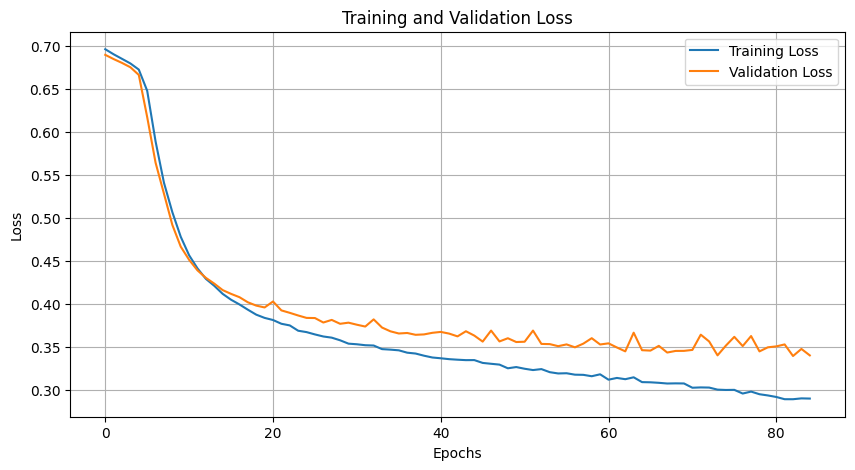

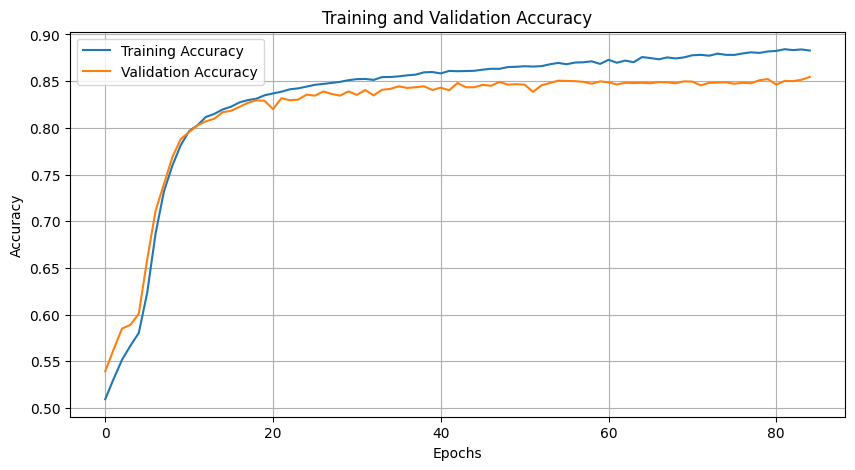

In [30]:
# Convert data to PyTorch tensors and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, dropout):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, 64, batch_first=True)  # Hidden dimension set to 64
        self.fc = nn.Linear(64, 1)  # Single neuron output layer
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        # Taking the last hidden state
        last_hidden_state = gru_out[:, -1, :]
        dropped_out = self.dropout(last_hidden_state)
        output = self.fc(dropped_out)
        return self.sigmoid(output)


# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0.43
batch_size = 256
num_epochs = 85
learning_rate = 0.0001
weight_decay = 12e-4

# Instantiate the model and move to device
model = GRUModel(input_dim, embedding_dim, hidden_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())
            val_loss += loss.item() * inputs.size(0)
            
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
    epoch_val_loss = val_loss / len(val_dataset)
    val_accuracy = correct_val_predictions / total_val_predictions
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#### Training Loss: 0.2901, Validation Loss: 0.3403,
#### Train Accuracy: 0.8828, Validation Accuracy: 0.8545, Test Accuracy: 0.8545
#### Compute Train: 45 seconds


# PREVIOUS ATTEMPTS

/tmp/ipykernel_2933/3335518968.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_2933/3335518968.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_2933/3335518968.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_2933/3335518968.py:13: UserWarning: To copy construct from a tensor, it is recommended to use s

Epoch 1/85, Loss: 0.6989, Validation Loss: 0.6980, Train Accuracy: 0.4925, Validation Accuracy: 0.4913
Epoch 2/85, Loss: 0.6947, Validation Loss: 0.6946, Train Accuracy: 0.5068, Validation Accuracy: 0.5092
Epoch 3/85, Loss: 0.6912, Validation Loss: 0.6917, Train Accuracy: 0.5242, Validation Accuracy: 0.5230
Epoch 4/85, Loss: 0.6881, Validation Loss: 0.6890, Train Accuracy: 0.5403, Validation Accuracy: 0.5405
Epoch 5/85, Loss: 0.6851, Validation Loss: 0.6864, Train Accuracy: 0.5546, Validation Accuracy: 0.5475
Epoch 6/85, Loss: 0.6821, Validation Loss: 0.6839, Train Accuracy: 0.5652, Validation Accuracy: 0.5583
Epoch 7/85, Loss: 0.6791, Validation Loss: 0.6812, Train Accuracy: 0.5749, Validation Accuracy: 0.5663
Epoch 8/85, Loss: 0.6758, Validation Loss: 0.6782, Train Accuracy: 0.5827, Validation Accuracy: 0.5737
Epoch 9/85, Loss: 0.6722, Validation Loss: 0.6749, Train Accuracy: 0.5897, Validation Accuracy: 0.5900
Epoch 10/85, Loss: 0.6679, Validation Loss: 0.6707, Train Accuracy: 0.598

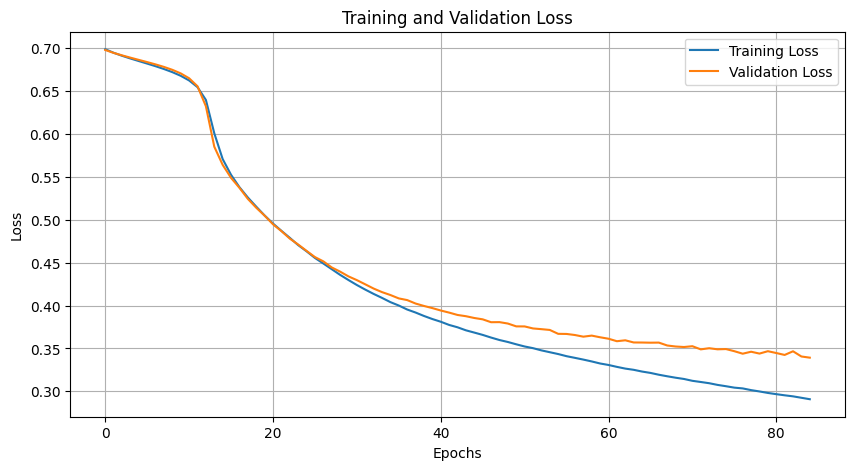

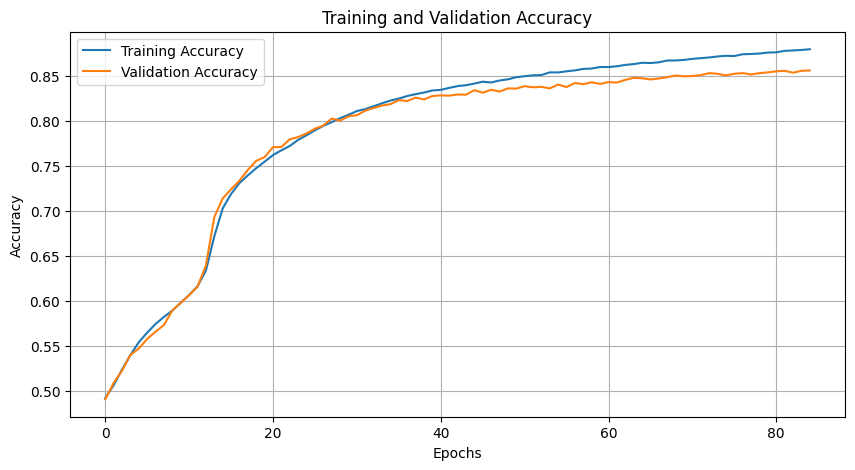

In [13]:
# Convert data to PyTorch tensors and move to device
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Convert data to PyTorch tensors and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

class GRUModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        # Taking the last hidden state to pass to the output layer
        last_hidden = gru_out[:, -1, :]
        output = self.fc(last_hidden)
        return self.sigmoid(output)

# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0.43
batch_size = 256
num_epochs = 85
learning_rate = 0.00003
weight_decay = 7e-5

# Instantiate the model and move to device
model = GRUModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")


# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_4065/920981848.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_4065/920981848.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_4065/920981848.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_4065/920981848.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourc

Epoch 1/85, Loss: 0.6966, Validation Loss: 0.6934, Train Accuracy: 0.5066, Validation Accuracy: 0.5262
Epoch 2/85, Loss: 0.6914, Validation Loss: 0.6888, Train Accuracy: 0.5287, Validation Accuracy: 0.5355
Epoch 3/85, Loss: 0.6873, Validation Loss: 0.6851, Train Accuracy: 0.5476, Validation Accuracy: 0.5515
Epoch 4/85, Loss: 0.6836, Validation Loss: 0.6815, Train Accuracy: 0.5626, Validation Accuracy: 0.5635
Epoch 5/85, Loss: 0.6801, Validation Loss: 0.6780, Train Accuracy: 0.5714, Validation Accuracy: 0.5795
Epoch 6/85, Loss: 0.6764, Validation Loss: 0.6742, Train Accuracy: 0.5810, Validation Accuracy: 0.5873
Epoch 7/85, Loss: 0.6720, Validation Loss: 0.6695, Train Accuracy: 0.5914, Validation Accuracy: 0.5970
Epoch 8/85, Loss: 0.6663, Validation Loss: 0.6628, Train Accuracy: 0.6024, Validation Accuracy: 0.6075
Epoch 9/85, Loss: 0.6566, Validation Loss: 0.6486, Train Accuracy: 0.6157, Validation Accuracy: 0.6265
Epoch 10/85, Loss: 0.6236, Validation Loss: 0.6026, Train Accuracy: 0.651

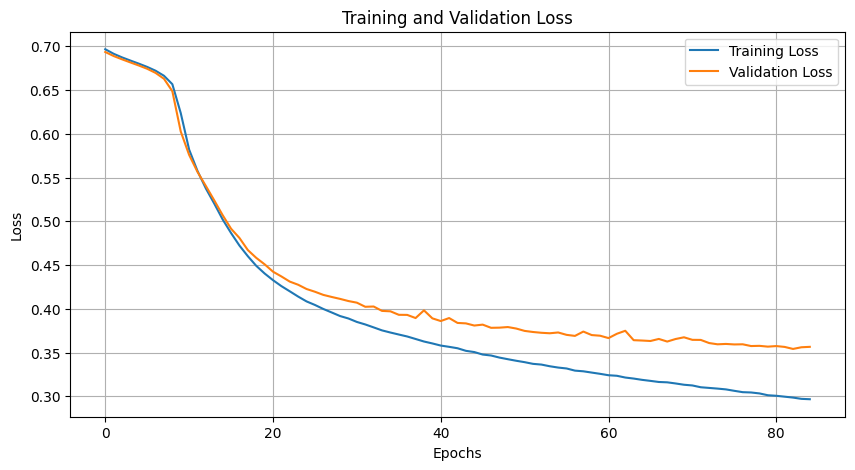

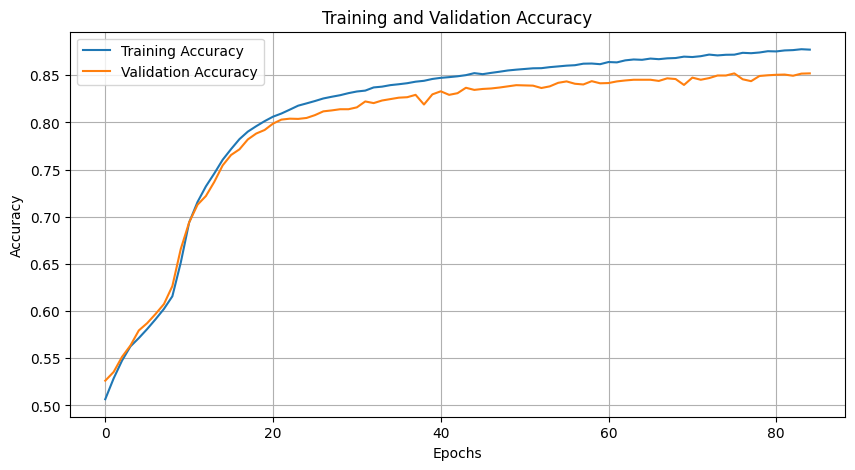

In [14]:
# Convert data to PyTorch tensors and move to device
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Convert data to PyTorch tensors and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

class GRUModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        # Taking the last hidden state to pass to the output layer
        last_hidden = gru_out[:, -1, :]
        output = self.fc(last_hidden)
        return self.sigmoid(output)

# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0.45
batch_size = 256
num_epochs = 85
learning_rate = 0.00005
weight_decay = 6e-4

# Instantiate the model and move to device
model = GRUModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")


# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_4065/3484853280.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_4065/3484853280.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_4065/3484853280.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_4065/3484853280.py:13: UserWarning: To copy construct from a tensor, it is recommended to use s

Epoch 1/85, Loss: 0.6924, Validation Loss: 0.6908, Train Accuracy: 0.5222, Validation Accuracy: 0.5310
Epoch 2/85, Loss: 0.6892, Validation Loss: 0.6874, Train Accuracy: 0.5383, Validation Accuracy: 0.5453
Epoch 3/85, Loss: 0.6862, Validation Loss: 0.6841, Train Accuracy: 0.5496, Validation Accuracy: 0.5597
Epoch 4/85, Loss: 0.6832, Validation Loss: 0.6807, Train Accuracy: 0.5605, Validation Accuracy: 0.5760
Epoch 5/85, Loss: 0.6801, Validation Loss: 0.6770, Train Accuracy: 0.5702, Validation Accuracy: 0.5823
Epoch 6/85, Loss: 0.6767, Validation Loss: 0.6730, Train Accuracy: 0.5797, Validation Accuracy: 0.5910
Epoch 7/85, Loss: 0.6727, Validation Loss: 0.6682, Train Accuracy: 0.5886, Validation Accuracy: 0.6048
Epoch 8/85, Loss: 0.6678, Validation Loss: 0.6619, Train Accuracy: 0.5979, Validation Accuracy: 0.6115
Epoch 9/85, Loss: 0.6610, Validation Loss: 0.6527, Train Accuracy: 0.6094, Validation Accuracy: 0.6290
Epoch 10/85, Loss: 0.6490, Validation Loss: 0.6346, Train Accuracy: 0.624

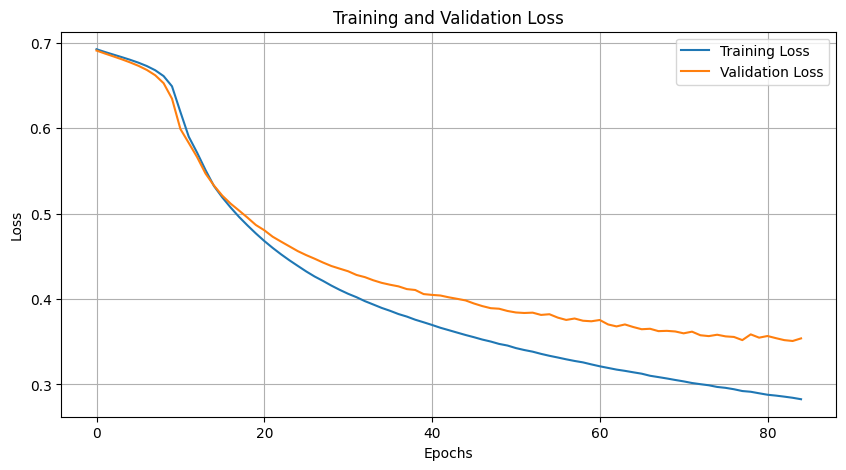

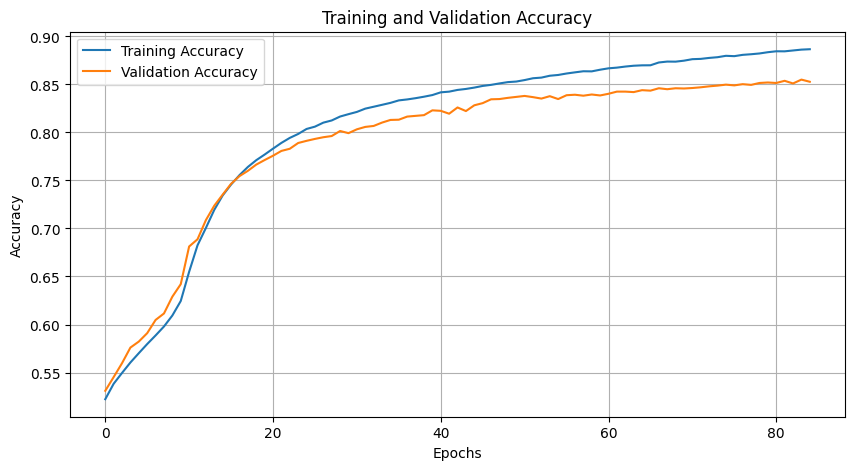

In [18]:
# Convert data to PyTorch tensors and move to device
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Convert data to PyTorch tensors and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

class GRUModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        # Taking the last hidden state to pass to the output layer
        last_hidden = gru_out[:, -1, :]
        output = self.fc(last_hidden)
        return self.sigmoid(output)

# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0.45
batch_size = 256
num_epochs = 85
learning_rate = 0.00003
weight_decay = 5e-5

# Instantiate the model and move to device
model = GRUModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")


# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_2933/115889631.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_2933/115889631.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_2933/115889631.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_2933/115889631.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourc

Epoch 1/85, Loss: 0.6973, Validation Loss: 0.6944, Train Accuracy: 0.5026, Validation Accuracy: 0.5102
Epoch 2/85, Loss: 0.6933, Validation Loss: 0.6911, Train Accuracy: 0.5169, Validation Accuracy: 0.5272
Epoch 3/85, Loss: 0.6902, Validation Loss: 0.6884, Train Accuracy: 0.5338, Validation Accuracy: 0.5445
Epoch 4/85, Loss: 0.6875, Validation Loss: 0.6860, Train Accuracy: 0.5483, Validation Accuracy: 0.5545
Epoch 5/85, Loss: 0.6850, Validation Loss: 0.6837, Train Accuracy: 0.5594, Validation Accuracy: 0.5593
Epoch 6/85, Loss: 0.6826, Validation Loss: 0.6814, Train Accuracy: 0.5674, Validation Accuracy: 0.5713
Epoch 7/85, Loss: 0.6800, Validation Loss: 0.6790, Train Accuracy: 0.5739, Validation Accuracy: 0.5800
Epoch 8/85, Loss: 0.6772, Validation Loss: 0.6763, Train Accuracy: 0.5794, Validation Accuracy: 0.5820
Epoch 9/85, Loss: 0.6739, Validation Loss: 0.6730, Train Accuracy: 0.5871, Validation Accuracy: 0.5875
Epoch 10/85, Loss: 0.6699, Validation Loss: 0.6688, Train Accuracy: 0.594

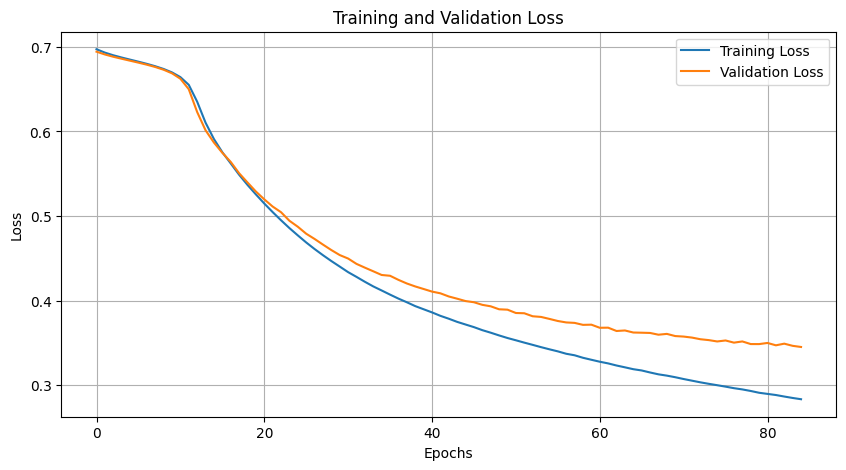

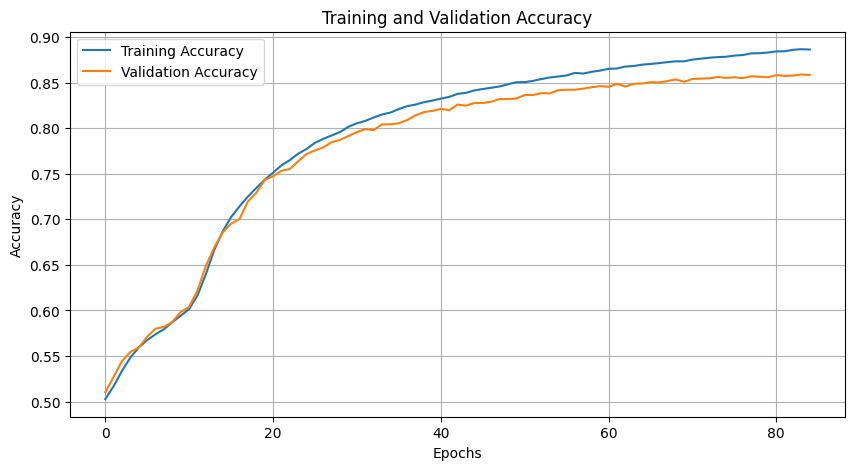

In [11]:
# Convert data to PyTorch tensors and move to device
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Convert data to PyTorch tensors and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

class GRUModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        # Taking the last hidden state to pass to the output layer
        last_hidden = gru_out[:, -1, :]
        output = self.fc(last_hidden)
        return self.sigmoid(output)

# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0.35
batch_size = 256
num_epochs = 85
learning_rate = 0.00003
weight_decay = 3e-5

# Instantiate the model and move to device
model = GRUModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")


# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_2933/3044951238.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_2933/3044951238.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_2933/3044951238.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_2933/3044951238.py:13: UserWarning: To copy construct from a tensor, it is recommended to use s

Epoch 1/100, Loss: 0.6954, Validation Loss: 0.6934, Train Accuracy: 0.5049, Validation Accuracy: 0.5092
Epoch 2/100, Loss: 0.6917, Validation Loss: 0.6904, Train Accuracy: 0.5215, Validation Accuracy: 0.5262
Epoch 3/100, Loss: 0.6889, Validation Loss: 0.6880, Train Accuracy: 0.5361, Validation Accuracy: 0.5365
Epoch 4/100, Loss: 0.6864, Validation Loss: 0.6858, Train Accuracy: 0.5494, Validation Accuracy: 0.5483
Epoch 5/100, Loss: 0.6840, Validation Loss: 0.6837, Train Accuracy: 0.5568, Validation Accuracy: 0.5590
Epoch 6/100, Loss: 0.6817, Validation Loss: 0.6816, Train Accuracy: 0.5646, Validation Accuracy: 0.5630
Epoch 7/100, Loss: 0.6793, Validation Loss: 0.6794, Train Accuracy: 0.5694, Validation Accuracy: 0.5683
Epoch 8/100, Loss: 0.6766, Validation Loss: 0.6770, Train Accuracy: 0.5753, Validation Accuracy: 0.5727
Epoch 9/100, Loss: 0.6737, Validation Loss: 0.6742, Train Accuracy: 0.5820, Validation Accuracy: 0.5790
Epoch 10/100, Loss: 0.6702, Validation Loss: 0.6709, Train Accur

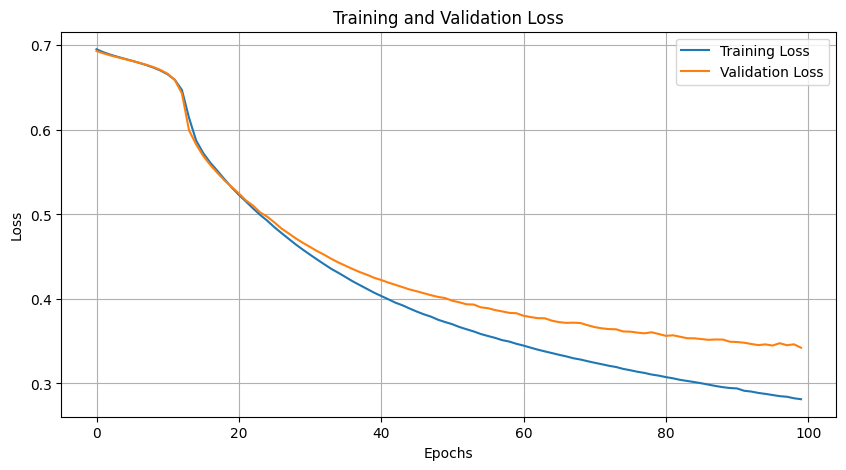

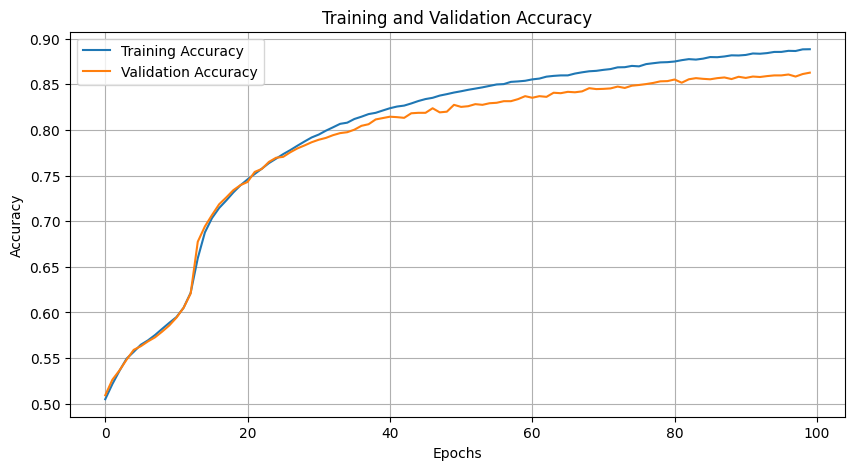

In [15]:
# Convert data to PyTorch tensors and move to device
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Convert data to PyTorch tensors and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

class GRUModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        # Taking the last hidden state to pass to the output layer
        last_hidden = gru_out[:, -1, :]
        output = self.fc(last_hidden)
        return self.sigmoid(output)

# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0.43
batch_size = 256
num_epochs = 100
learning_rate = 0.00003
weight_decay = 7e-5

# Instantiate the model and move to device
model = GRUModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")


# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_2933/3421637439.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_2933/3421637439.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_2933/3421637439.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_2933/3421637439.py:13: UserWarning: To copy construct from a tensor, it is recommended to use s

Epoch 1/85, Loss: 0.6986, Validation Loss: 0.6959, Train Accuracy: 0.4969, Validation Accuracy: 0.5078
Epoch 2/85, Loss: 0.6948, Validation Loss: 0.6930, Train Accuracy: 0.5090, Validation Accuracy: 0.5160
Epoch 3/85, Loss: 0.6917, Validation Loss: 0.6907, Train Accuracy: 0.5242, Validation Accuracy: 0.5165
Epoch 4/85, Loss: 0.6891, Validation Loss: 0.6886, Train Accuracy: 0.5400, Validation Accuracy: 0.5337
Epoch 5/85, Loss: 0.6868, Validation Loss: 0.6867, Train Accuracy: 0.5532, Validation Accuracy: 0.5427
Epoch 6/85, Loss: 0.6845, Validation Loss: 0.6849, Train Accuracy: 0.5619, Validation Accuracy: 0.5533
Epoch 7/85, Loss: 0.6823, Validation Loss: 0.6831, Train Accuracy: 0.5686, Validation Accuracy: 0.5593
Epoch 8/85, Loss: 0.6800, Validation Loss: 0.6812, Train Accuracy: 0.5749, Validation Accuracy: 0.5590
Epoch 9/85, Loss: 0.6776, Validation Loss: 0.6792, Train Accuracy: 0.5806, Validation Accuracy: 0.5607
Epoch 10/85, Loss: 0.6750, Validation Loss: 0.6769, Train Accuracy: 0.584

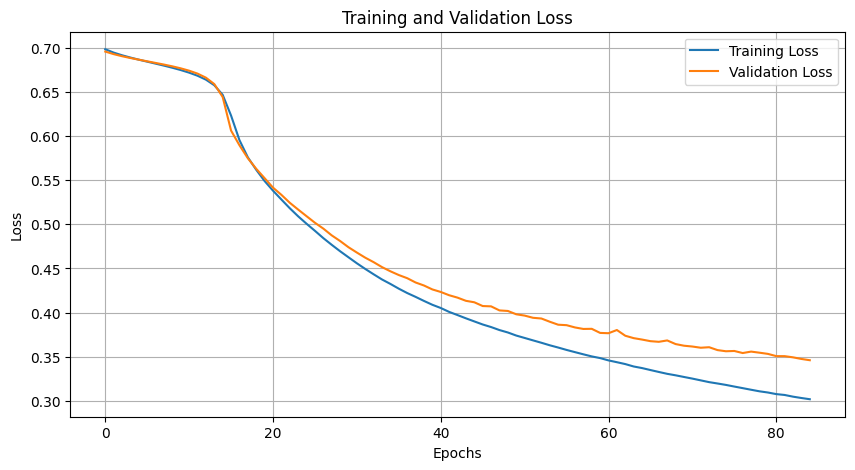

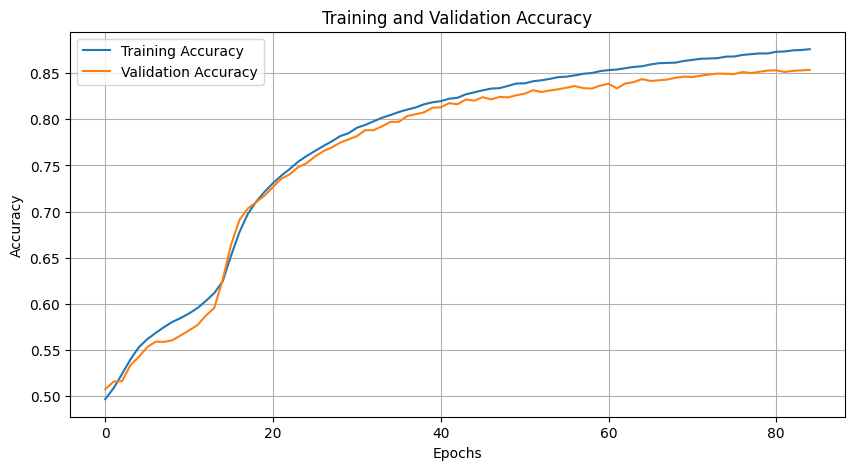

In [14]:
# Convert data to PyTorch tensors and move to device
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Convert data to PyTorch tensors and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

class GRUModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        # Taking the last hidden state to pass to the output layer
        last_hidden = gru_out[:, -1, :]
        output = self.fc(last_hidden)
        return self.sigmoid(output)

# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0.47
batch_size = 256
num_epochs = 85
learning_rate = 0.00003
weight_decay = 7e-5

# Instantiate the model and move to device
model = GRUModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")


# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_938/440930723.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_938/440930723.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_938/440930723.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_938/440930723.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

Epoch 1/85, Loss: 0.6936, Validation Loss: 0.6848, Train Accuracy: 0.5195, Validation Accuracy: 0.5567
Epoch 2/85, Loss: 0.6855, Validation Loss: 0.6790, Train Accuracy: 0.5467, Validation Accuracy: 0.5653
Epoch 3/85, Loss: 0.6792, Validation Loss: 0.6731, Train Accuracy: 0.5658, Validation Accuracy: 0.5757
Epoch 4/85, Loss: 0.6703, Validation Loss: 0.6629, Train Accuracy: 0.5861, Validation Accuracy: 0.5962
Epoch 5/85, Loss: 0.6426, Validation Loss: 0.6077, Train Accuracy: 0.6244, Validation Accuracy: 0.6653
Epoch 6/85, Loss: 0.5807, Validation Loss: 0.5617, Train Accuracy: 0.6980, Validation Accuracy: 0.7087
Epoch 7/85, Loss: 0.5386, Validation Loss: 0.5257, Train Accuracy: 0.7331, Validation Accuracy: 0.7375
Epoch 8/85, Loss: 0.5039, Validation Loss: 0.4934, Train Accuracy: 0.7580, Validation Accuracy: 0.7670
Epoch 9/85, Loss: 0.4758, Validation Loss: 0.4718, Train Accuracy: 0.7787, Validation Accuracy: 0.7812
Epoch 10/85, Loss: 0.4531, Validation Loss: 0.4508, Train Accuracy: 0.793

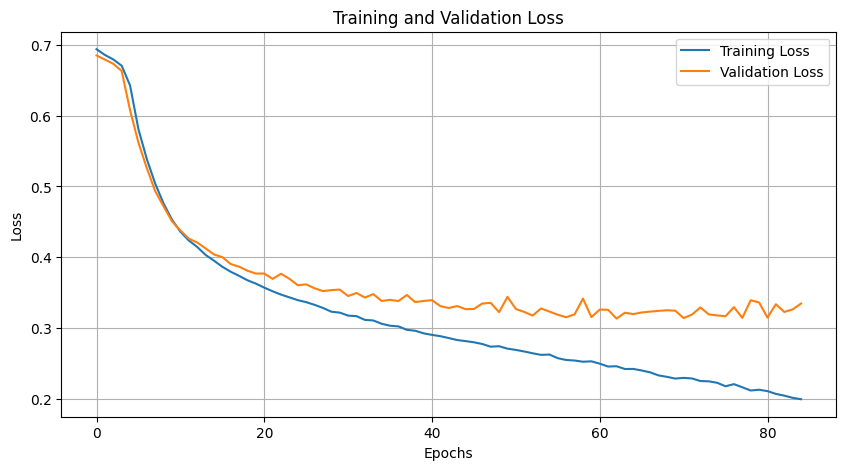

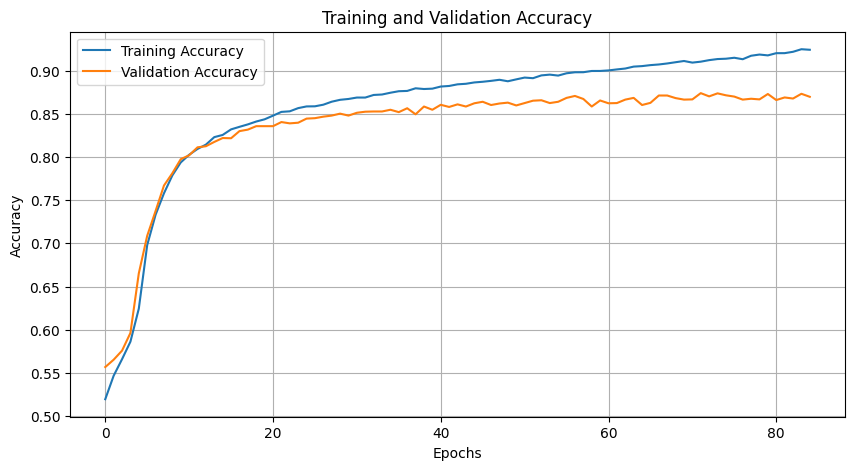

In [24]:
# Convert data to PyTorch tensors and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, dropout):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, 64, batch_first=True)  # Hidden dimension set to 64
        self.fc = nn.Linear(64, 1)  # Single neuron output layer
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        # Taking the last hidden state
        last_hidden_state = gru_out[:, -1, :]
        dropped_out = self.dropout(last_hidden_state)
        output = self.fc(dropped_out)
        return self.sigmoid(output)


# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0.35
batch_size = 256
num_epochs = 85
learning_rate = 0.0001
weight_decay = 3e-4

# Instantiate the model and move to device
model = GRUModel(input_dim, embedding_dim, hidden_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())
            val_loss += loss.item() * inputs.size(0)
            
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
    epoch_val_loss = val_loss / len(val_dataset)
    val_accuracy = correct_val_predictions / total_val_predictions
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_938/2722263463.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_938/2722263463.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_938/2722263463.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_938/2722263463.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTen

Epoch 1/85, Loss: 0.6964, Validation Loss: 0.6908, Train Accuracy: 0.5091, Validation Accuracy: 0.5238
Epoch 2/85, Loss: 0.6879, Validation Loss: 0.6843, Train Accuracy: 0.5380, Validation Accuracy: 0.5463
Epoch 3/85, Loss: 0.6808, Validation Loss: 0.6782, Train Accuracy: 0.5612, Validation Accuracy: 0.5685
Epoch 4/85, Loss: 0.6724, Validation Loss: 0.6690, Train Accuracy: 0.5811, Validation Accuracy: 0.5847
Epoch 5/85, Loss: 0.6499, Validation Loss: 0.6184, Train Accuracy: 0.6157, Validation Accuracy: 0.6637
Epoch 6/85, Loss: 0.5822, Validation Loss: 0.5700, Train Accuracy: 0.6937, Validation Accuracy: 0.7040
Epoch 7/85, Loss: 0.5437, Validation Loss: 0.5367, Train Accuracy: 0.7320, Validation Accuracy: 0.7362
Epoch 8/85, Loss: 0.5139, Validation Loss: 0.5110, Train Accuracy: 0.7531, Validation Accuracy: 0.7535
Epoch 9/85, Loss: 0.4870, Validation Loss: 0.4902, Train Accuracy: 0.7727, Validation Accuracy: 0.7672
Epoch 10/85, Loss: 0.4650, Validation Loss: 0.4697, Train Accuracy: 0.788

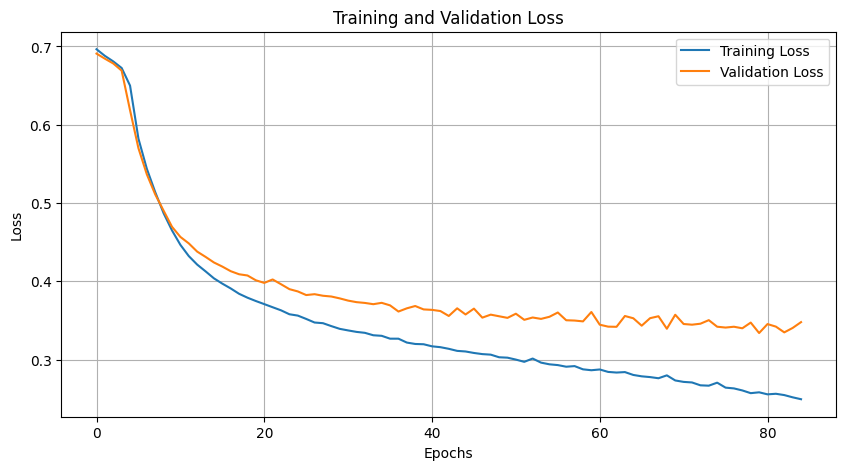

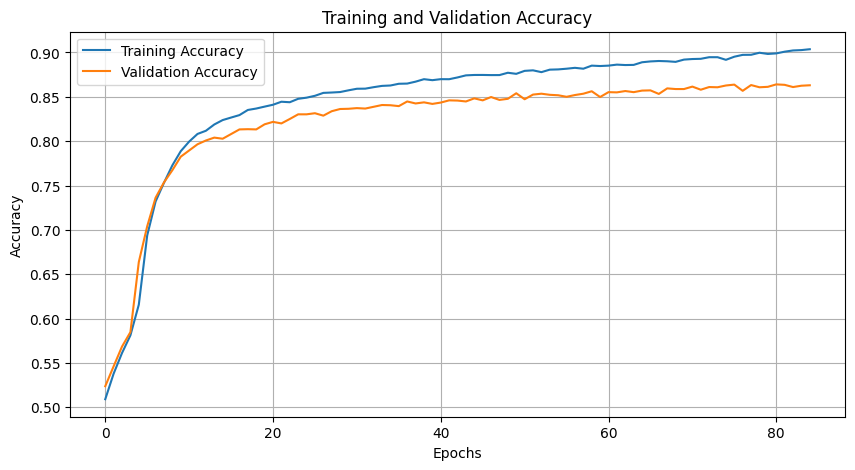

In [25]:
# Convert data to PyTorch tensors and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, dropout):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, 64, batch_first=True)  # Hidden dimension set to 64
        self.fc = nn.Linear(64, 1)  # Single neuron output layer
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        # Taking the last hidden state
        last_hidden_state = gru_out[:, -1, :]
        dropped_out = self.dropout(last_hidden_state)
        output = self.fc(dropped_out)
        return self.sigmoid(output)


# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0.35
batch_size = 256
num_epochs = 85
learning_rate = 0.0001
weight_decay = 7e-4

# Instantiate the model and move to device
model = GRUModel(input_dim, embedding_dim, hidden_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())
            val_loss += loss.item() * inputs.size(0)
            
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
    epoch_val_loss = val_loss / len(val_dataset)
    val_accuracy = correct_val_predictions / total_val_predictions
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_938/3171124071.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_938/3171124071.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_938/3171124071.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_938/3171124071.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTen

Epoch 1/85, Loss: 0.6952, Validation Loss: 0.6892, Train Accuracy: 0.5084, Validation Accuracy: 0.5335
Epoch 2/85, Loss: 0.6891, Validation Loss: 0.6841, Train Accuracy: 0.5329, Validation Accuracy: 0.5550
Epoch 3/85, Loss: 0.6852, Validation Loss: 0.6797, Train Accuracy: 0.5480, Validation Accuracy: 0.5725
Epoch 4/85, Loss: 0.6815, Validation Loss: 0.6749, Train Accuracy: 0.5583, Validation Accuracy: 0.5885
Epoch 5/85, Loss: 0.6766, Validation Loss: 0.6686, Train Accuracy: 0.5697, Validation Accuracy: 0.6002
Epoch 6/85, Loss: 0.6687, Validation Loss: 0.6554, Train Accuracy: 0.5841, Validation Accuracy: 0.6198
Epoch 7/85, Loss: 0.6365, Validation Loss: 0.5884, Train Accuracy: 0.6334, Validation Accuracy: 0.6915
Epoch 8/85, Loss: 0.5699, Validation Loss: 0.5389, Train Accuracy: 0.7066, Validation Accuracy: 0.7330
Epoch 9/85, Loss: 0.5258, Validation Loss: 0.4980, Train Accuracy: 0.7439, Validation Accuracy: 0.7690
Epoch 10/85, Loss: 0.4911, Validation Loss: 0.4736, Train Accuracy: 0.769

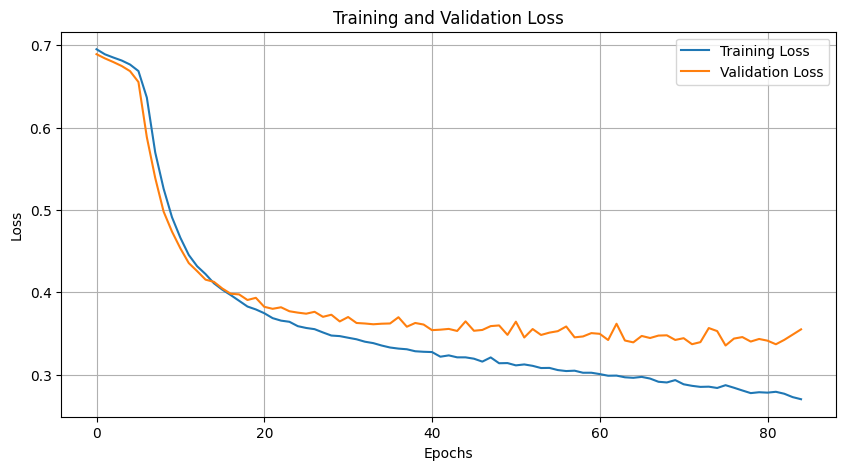

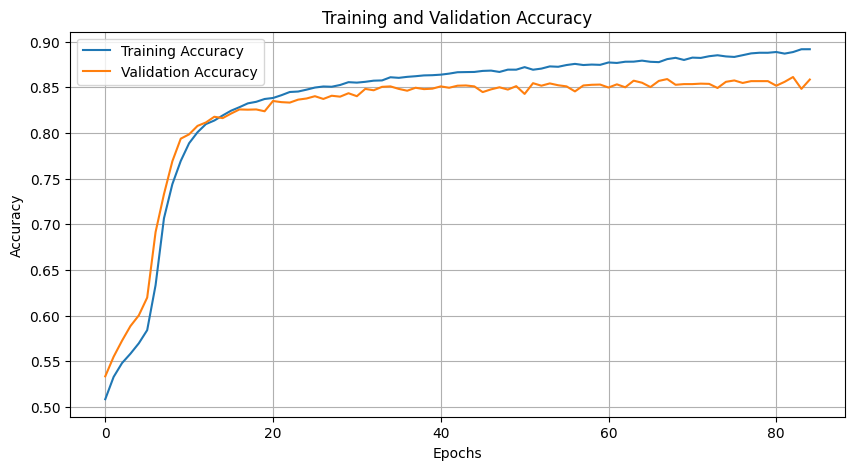

In [26]:
# Convert data to PyTorch tensors and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, dropout):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, 64, batch_first=True)  # Hidden dimension set to 64
        self.fc = nn.Linear(64, 1)  # Single neuron output layer
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        # Taking the last hidden state
        last_hidden_state = gru_out[:, -1, :]
        dropped_out = self.dropout(last_hidden_state)
        output = self.fc(dropped_out)
        return self.sigmoid(output)


# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0.4
batch_size = 256
num_epochs = 85
learning_rate = 0.0001
weight_decay = 9e-4

# Instantiate the model and move to device
model = GRUModel(input_dim, embedding_dim, hidden_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())
            val_loss += loss.item() * inputs.size(0)
            
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
    epoch_val_loss = val_loss / len(val_dataset)
    val_accuracy = correct_val_predictions / total_val_predictions
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_938/3790118700.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_938/3790118700.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_938/3790118700.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_938/3790118700.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTen

Epoch 1/85, Loss: 0.6939, Validation Loss: 0.6913, Train Accuracy: 0.5160, Validation Accuracy: 0.5262
Epoch 2/85, Loss: 0.6888, Validation Loss: 0.6867, Train Accuracy: 0.5385, Validation Accuracy: 0.5427
Epoch 3/85, Loss: 0.6838, Validation Loss: 0.6823, Train Accuracy: 0.5569, Validation Accuracy: 0.5570
Epoch 4/85, Loss: 0.6793, Validation Loss: 0.6766, Train Accuracy: 0.5681, Validation Accuracy: 0.5733
Epoch 5/85, Loss: 0.6705, Validation Loss: 0.6636, Train Accuracy: 0.5844, Validation Accuracy: 0.6000
Epoch 6/85, Loss: 0.6353, Validation Loss: 0.5965, Train Accuracy: 0.6357, Validation Accuracy: 0.6873
Epoch 7/85, Loss: 0.5765, Validation Loss: 0.5465, Train Accuracy: 0.7035, Validation Accuracy: 0.7282
Epoch 8/85, Loss: 0.5329, Validation Loss: 0.5010, Train Accuracy: 0.7416, Validation Accuracy: 0.7668
Epoch 9/85, Loss: 0.4932, Validation Loss: 0.4702, Train Accuracy: 0.7716, Validation Accuracy: 0.7835
Epoch 10/85, Loss: 0.4651, Validation Loss: 0.4502, Train Accuracy: 0.789

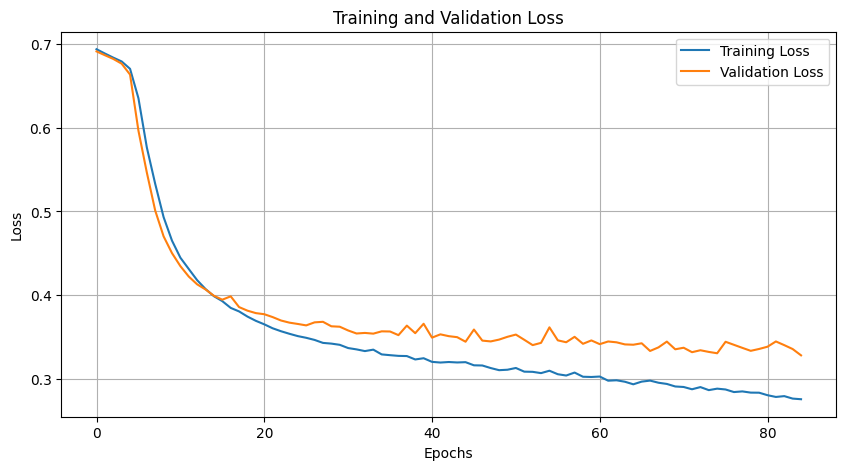

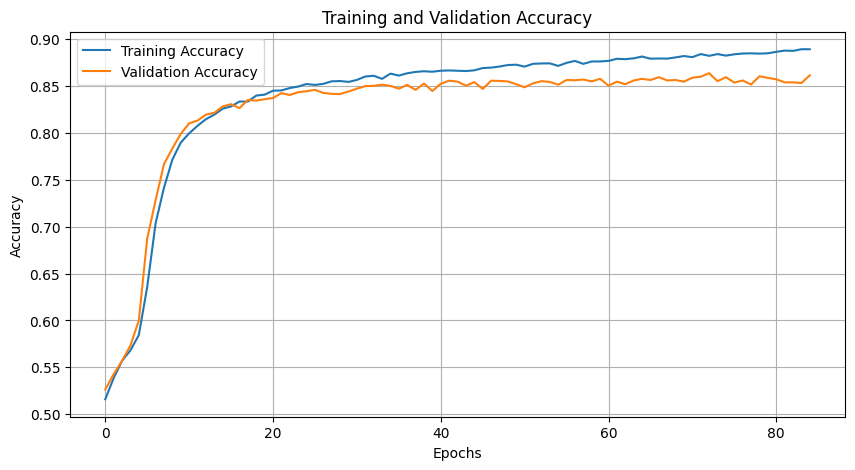

In [27]:
# Convert data to PyTorch tensors and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, dropout):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, 64, batch_first=True)  # Hidden dimension set to 64
        self.fc = nn.Linear(64, 1)  # Single neuron output layer
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        # Taking the last hidden state
        last_hidden_state = gru_out[:, -1, :]
        dropped_out = self.dropout(last_hidden_state)
        output = self.fc(dropped_out)
        return self.sigmoid(output)


# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0.4
batch_size = 256
num_epochs = 85
learning_rate = 0.0001
weight_decay = 11e-4

# Instantiate the model and move to device
model = GRUModel(input_dim, embedding_dim, hidden_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())
            val_loss += loss.item() * inputs.size(0)
            
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
    epoch_val_loss = val_loss / len(val_dataset)
    val_accuracy = correct_val_predictions / total_val_predictions
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_938/406976368.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_938/406976368.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_938/406976368.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_938/406976368.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

Epoch 1/85, Loss: 0.6920, Validation Loss: 0.6856, Train Accuracy: 0.5268, Validation Accuracy: 0.5563
Epoch 2/85, Loss: 0.6843, Validation Loss: 0.6783, Train Accuracy: 0.5536, Validation Accuracy: 0.5817
Epoch 3/85, Loss: 0.6760, Validation Loss: 0.6694, Train Accuracy: 0.5764, Validation Accuracy: 0.5940
Epoch 4/85, Loss: 0.6628, Validation Loss: 0.6497, Train Accuracy: 0.6009, Validation Accuracy: 0.6312
Epoch 5/85, Loss: 0.6155, Validation Loss: 0.5766, Train Accuracy: 0.6616, Validation Accuracy: 0.7035
Epoch 6/85, Loss: 0.5627, Validation Loss: 0.5439, Train Accuracy: 0.7159, Validation Accuracy: 0.7295
Epoch 7/85, Loss: 0.5304, Validation Loss: 0.5165, Train Accuracy: 0.7427, Validation Accuracy: 0.7550
Epoch 8/85, Loss: 0.4999, Validation Loss: 0.4890, Train Accuracy: 0.7652, Validation Accuracy: 0.7748
Epoch 9/85, Loss: 0.4723, Validation Loss: 0.4633, Train Accuracy: 0.7839, Validation Accuracy: 0.7905
Epoch 10/85, Loss: 0.4521, Validation Loss: 0.4492, Train Accuracy: 0.796

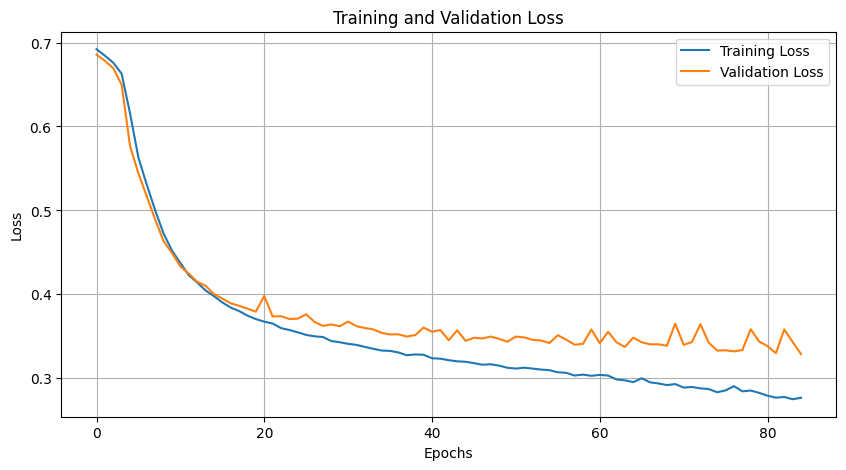

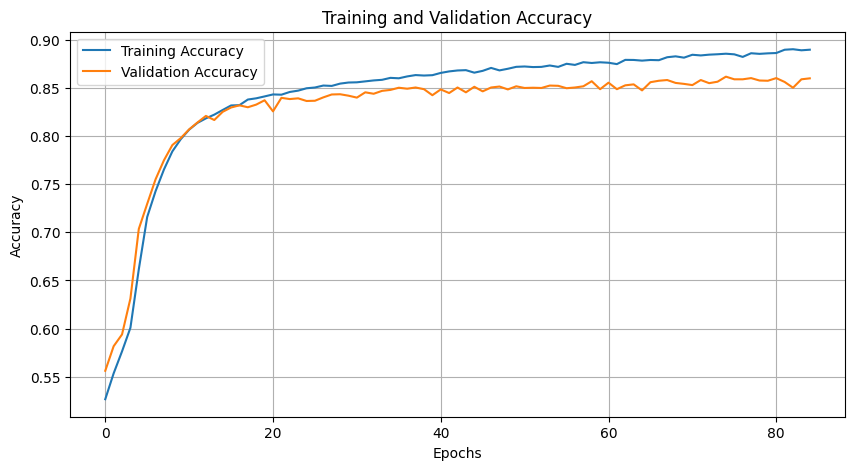

In [29]:
# Convert data to PyTorch tensors and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, dropout):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, 64, batch_first=True)  # Hidden dimension set to 64
        self.fc = nn.Linear(64, 1)  # Single neuron output layer
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        # Taking the last hidden state
        last_hidden_state = gru_out[:, -1, :]
        dropped_out = self.dropout(last_hidden_state)
        output = self.fc(dropped_out)
        return self.sigmoid(output)


# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0.43
batch_size = 256
num_epochs = 85
learning_rate = 0.0001
weight_decay = 11e-4

# Instantiate the model and move to device
model = GRUModel(input_dim, embedding_dim, hidden_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())
            val_loss += loss.item() * inputs.size(0)
            
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
    epoch_val_loss = val_loss / len(val_dataset)
    val_accuracy = correct_val_predictions / total_val_predictions
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# best

/tmp/ipykernel_938/2727333849.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_938/2727333849.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_938/2727333849.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_938/2727333849.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTen

Epoch 1/85, Loss: 0.6983, Validation Loss: 0.6937, Train Accuracy: 0.5014, Validation Accuracy: 0.5130
Epoch 2/85, Loss: 0.6925, Validation Loss: 0.6885, Train Accuracy: 0.5235, Validation Accuracy: 0.5295
Epoch 3/85, Loss: 0.6885, Validation Loss: 0.6843, Train Accuracy: 0.5390, Validation Accuracy: 0.5473
Epoch 4/85, Loss: 0.6843, Validation Loss: 0.6801, Train Accuracy: 0.5506, Validation Accuracy: 0.5637
Epoch 5/85, Loss: 0.6809, Validation Loss: 0.6752, Train Accuracy: 0.5599, Validation Accuracy: 0.5807
Epoch 6/85, Loss: 0.6754, Validation Loss: 0.6679, Train Accuracy: 0.5728, Validation Accuracy: 0.5988
Epoch 7/85, Loss: 0.6617, Validation Loss: 0.6342, Train Accuracy: 0.6007, Validation Accuracy: 0.6435
Epoch 8/85, Loss: 0.6107, Validation Loss: 0.5780, Train Accuracy: 0.6658, Validation Accuracy: 0.7040
Epoch 9/85, Loss: 0.5646, Validation Loss: 0.5398, Train Accuracy: 0.7139, Validation Accuracy: 0.7300
Epoch 10/85, Loss: 0.5223, Validation Loss: 0.5063, Train Accuracy: 0.749

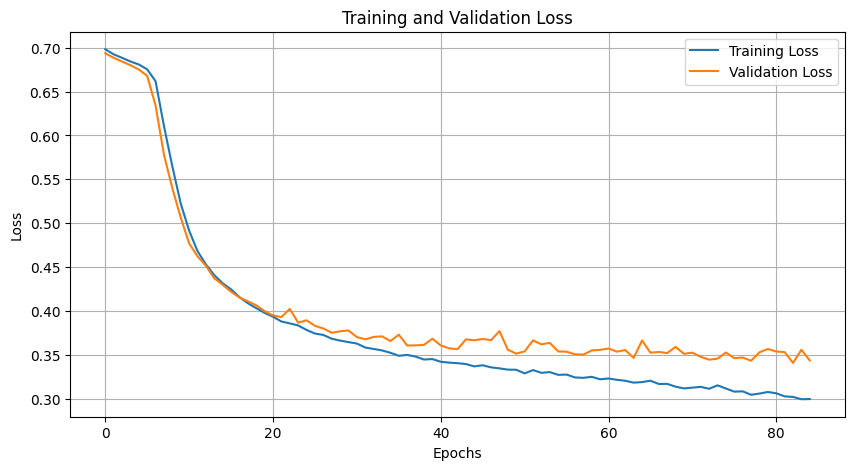

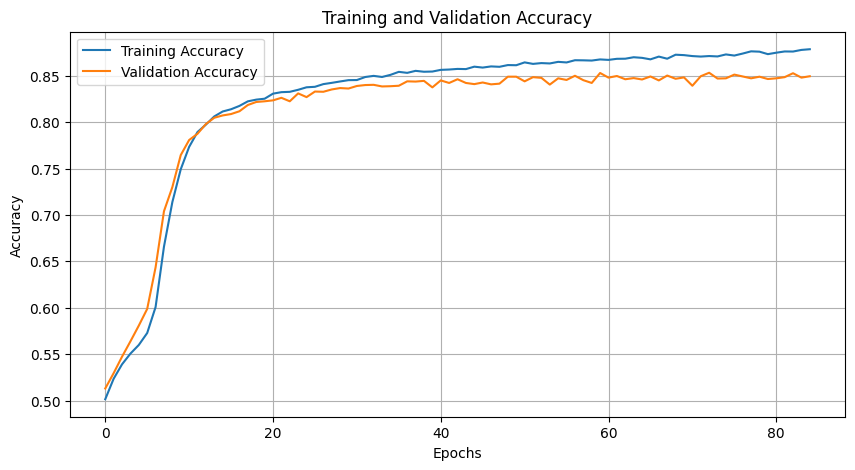

In [31]:
# Convert data to PyTorch tensors and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, dropout):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, 64, batch_first=True)  # Hidden dimension set to 64
        self.fc = nn.Linear(64, 1)  # Single neuron output layer
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        # Taking the last hidden state
        last_hidden_state = gru_out[:, -1, :]
        dropped_out = self.dropout(last_hidden_state)
        output = self.fc(dropped_out)
        return self.sigmoid(output)


# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0.43
batch_size = 256
num_epochs = 85
learning_rate = 0.00009
weight_decay = 12e-4

# Instantiate the model and move to device
model = GRUModel(input_dim, embedding_dim, hidden_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())
            val_loss += loss.item() * inputs.size(0)
            
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
    epoch_val_loss = val_loss / len(val_dataset)
    val_accuracy = correct_val_predictions / total_val_predictions
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()